In [124]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, precision_score, recall_score

result_dir = '../results/classification'
metrics = pd.DataFrame(columns=['Maximum Sequence Length', 'Cutting Method', 'Number of Epochs', 'TP', 'FN', 'FP', 'TN'])

for mx in [4, 6, 8]:
    for cut in ['After', 'Before']:
        gt = pd.read_csv(f'{result_dir}/max{mx}_cut{cut}/gt_test_labels.csv')

        for epochs in [5, 15]:
            pred_files = [i for i in glob.glob(f'{result_dir}/max{mx}_cut{cut}/{epochs}epochs/*.csv')]
            pred = pd.concat([pd.read_csv(f) for f in pred_files])
            merged = pd.merge(gt, pred, left_on='Read ID', right_on='Read ID')

            metrics = pd.concat([metrics, pd.DataFrame({
                'Maximum Sequence Length': [mx],
                'Cutting Method': [cut],
                'Number of Epochs': [epochs],
                'TP': [len(merged[(merged['Predicted Label'] == 'plasmid') & (merged['GT Label'] == 'plasmid')])],
                'TN': [len(merged[(merged['Predicted Label'] == 'chr') & (merged['GT Label'] == 'chr')])],
                'FP': [len(merged[(merged['Predicted Label'] == 'plasmid') & (merged['GT Label'] == 'chr')])],
                'FN': [len(merged[(merged['Predicted Label'] == 'chr') & (merged['GT Label'] == 'plasmid')])],
                'Balanced Accuracy': [balanced_accuracy_score(merged['GT Label'], merged['Predicted Label'])],  # (TPR + TNR) / 2
                'MCC': [matthews_corrcoef(merged['GT Label'], merged['Predicted Label'])],
                'Precision': [precision_score(merged['GT Label'], merged['Predicted Label'], pos_label='plasmid')],  # TP / (TP + FP)
                'Recall': [recall_score(merged['GT Label'], merged['Predicted Label'], pos_label='plasmid')],  # TP / (TP + FN)
            })], ignore_index=True)

            cm = confusion_matrix(merged['GT Label'], merged['Predicted Label'])
            cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
            cm_display.plot()
            plt.title(f'Confusion Matrix of Plasmid Classification\n(max sequence length: {mx}k, cutted: {cut.lower()} normalization, epochs: {epochs})')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig(f'../plots/max{mx}_cut{cut}_epochs{epochs}_confusion_matrix.png', dpi=300, facecolor='white')
            plt.close()

In [125]:
metrics['TPR'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])  # sensitivity/ recall
metrics['TNR'] = metrics['TN'] / (metrics['TN'] + metrics['FP'])  # specificity
metrics['FPR'] = metrics['FP'] / (metrics['FP'] + metrics['TN'])  # 1 - specificity
metrics['FNR'] = metrics['FN'] / (metrics['FN'] + metrics['TP'])

metrics['Accuracy'] = (metrics['TP'] + metrics['TN']) / (metrics['TP'] + metrics['TN'] + metrics['FP'] + metrics['FN'])
metrics['B. Acc'] = (metrics['TPR'] + metrics['TNR']) / 2
metrics['F1S'] = metrics['TP'] / (metrics['TP'] + 0.5 * (metrics['FP'] + metrics['FN']))  # harmonic mean between precision and recall

In [126]:
metrics.equals[['TPR', 'Recall']]

,TPR,Recall
0,0.000121,0.000121
1,0.000485,0.000485
2,0.0,0.000000
3,0.0,0.000000
4,0.001048,0.001048
5,0.056895,0.056895
6,0.0368,0.036800
7,0.093139,0.093139
8,0.065869,0.065869
9,0.167929,0.167929


In [128]:
metrics[['B. Acc', 'Balanced Accuracy']]

,B. Acc,Balanced Accuracy
0,0.500016,0.500016
1,0.500184,0.500184
2,0.499975,0.499975
3,0.499998,0.499998
4,0.500429,0.500429
5,0.526492,0.526492
6,0.516947,0.516947
7,0.544017,0.544017
8,0.530147,0.530147
9,0.579148,0.579148


In [129]:
metrics['ID'] = 'max' + metrics['Maximum Sequence Length'].astype(str) + '_cut' + metrics['Cutting Method'] + '_ep' + metrics['Number of Epochs'].astype(str)
metrics

,Maximum Sequence Length,Cutting Method,Number of Epochs,TP,FN,FP,TN,Balanced Accuracy,MCC,Precision,Recall,TPR,TNR,FPR,FNR,Accuracy,B. Acc,F1S,ID
0,4,After,5,2,16491,20,223381,0.500016,0.000839,0.090909,0.000121,0.000121,0.99991,0.00009,0.999879,0.931174,0.500016,0.000242,max4_cutAfter_ep5
1,4,After,15,8,16485,26,223375,0.500184,0.007836,0.235294,0.000485,0.000485,0.999884,0.000116,0.999515,0.931174,0.500184,0.000968,max4_cutAfter_ep15
2,4,Before,5,0,16493,11,223390,0.499975,-0.001840,0.000000,0.000000,0.0,0.999951,0.000049,1.0,0.931203,0.499975,0.0,max4_cutBefore_ep5
3,4,Before,15,0,16493,1,223400,0.499998,-0.000555,0.000000,0.000000,0.0,0.999996,0.000004,1.0,0.931245,0.499998,0.0,max4_cutBefore_ep15
4,6,After,5,17,16206,38,199962,0.500429,0.014172,0.309091,0.001048,0.001048,0.99981,0.00019,0.998952,0.924874,0.500429,0.002089,max6_cutAfter_ep5
5,6,After,15,923,15300,782,199218,0.526492,0.157810,0.541349,0.056895,0.056895,0.99609,0.00391,0.943105,0.925623,0.526492,0.102967,max6_cutAfter_ep15
6,6,Before,5,597,15626,581,199419,0.516947,0.121304,0.506791,0.036800,0.0368,0.997095,0.002905,0.9632,0.925045,0.516947,0.068617,max6_cutBefore_ep5
7,6,Before,15,1511,14712,1021,198979,0.544017,0.215580,0.596761,0.093139,0.093139,0.994895,0.005105,0.906861,0.927237,0.544017,0.16113,max6_cutBefore_ep15
8,8,After,5,1052,14919,997,177846,0.530147,0.162142,0.513421,0.065869,0.065869,0.994425,0.005575,0.934131,0.918302,0.530147,0.116759,max8_cutAfter_ep5
9,8,After,15,2682,13289,1723,177120,0.579148,0.292115,0.608854,0.167929,0.167929,0.990366,0.009634,0.832071,0.922942,0.579148,0.263251,max8_cutAfter_ep15


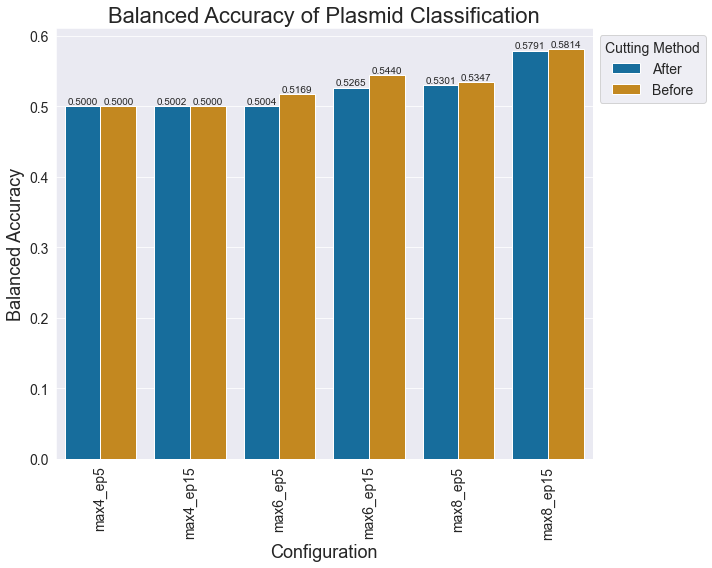

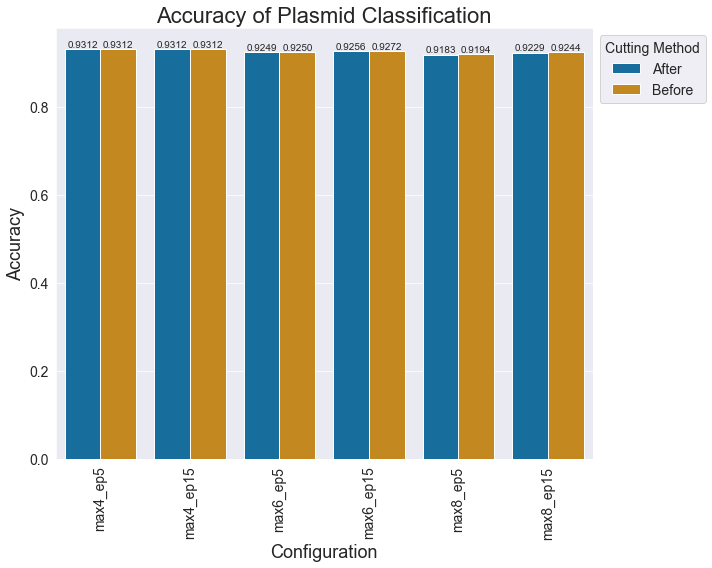

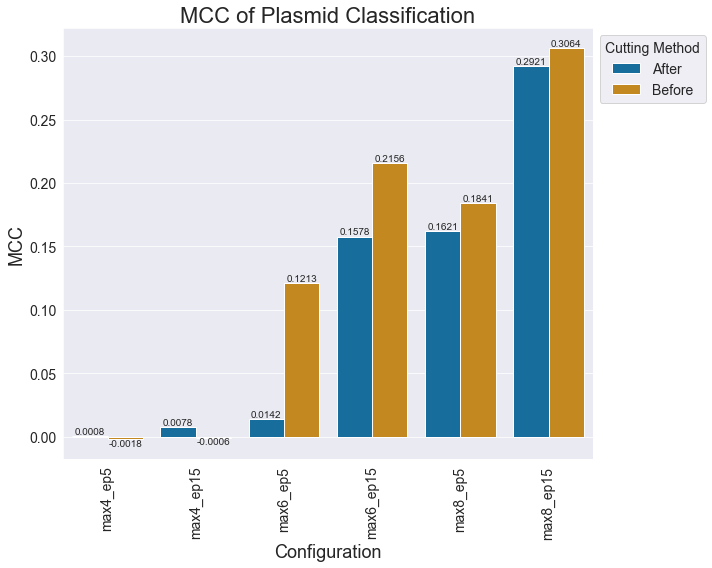

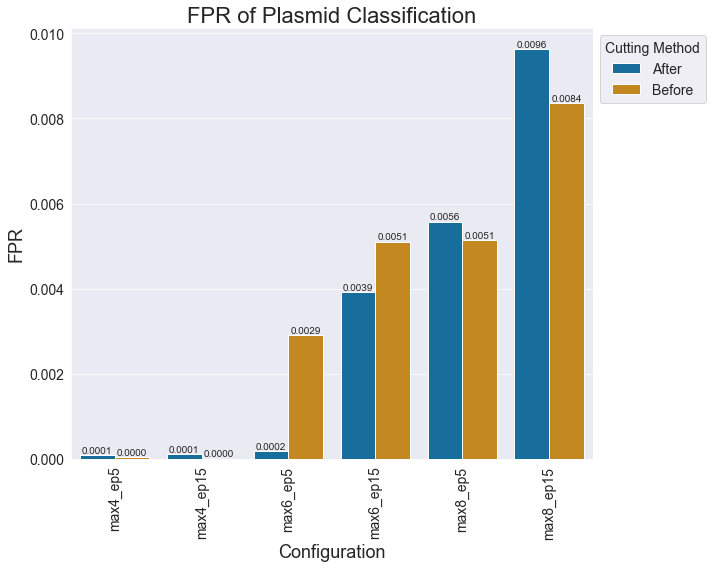

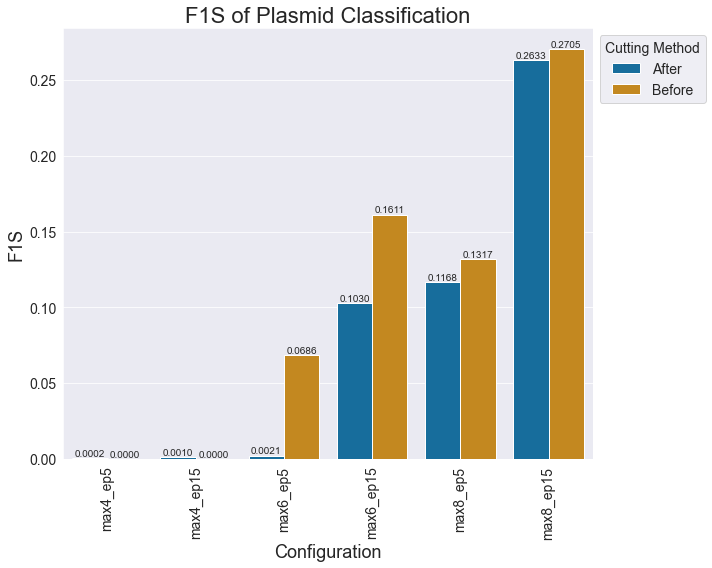

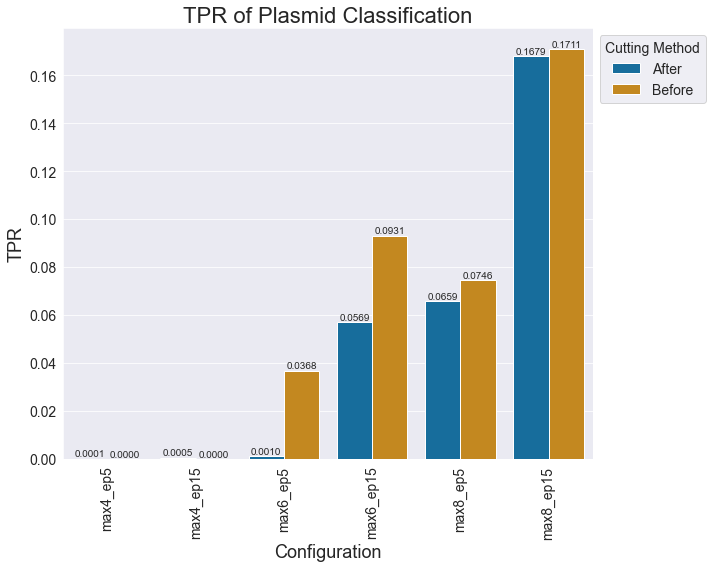

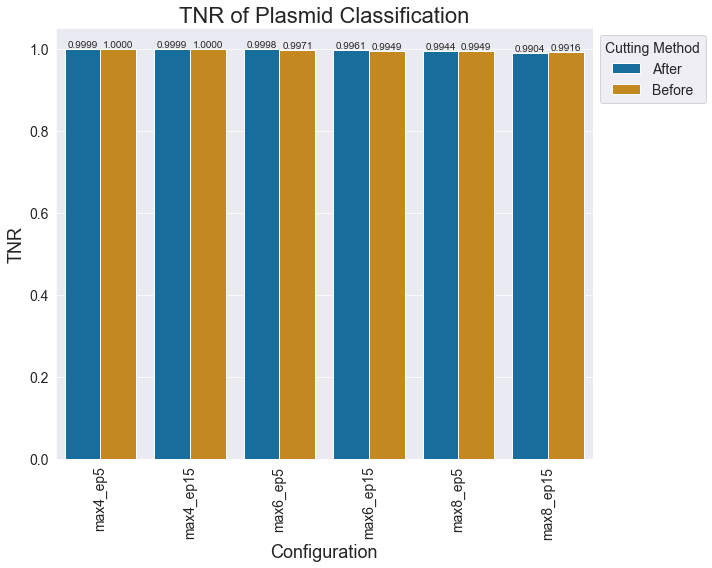

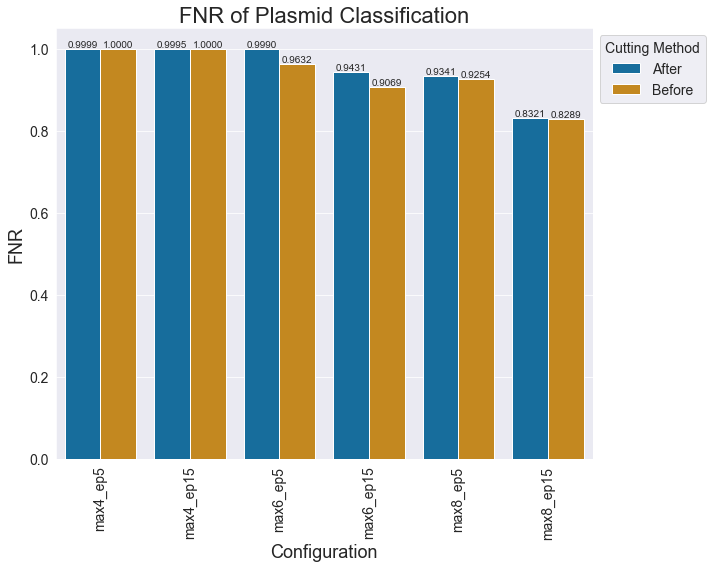

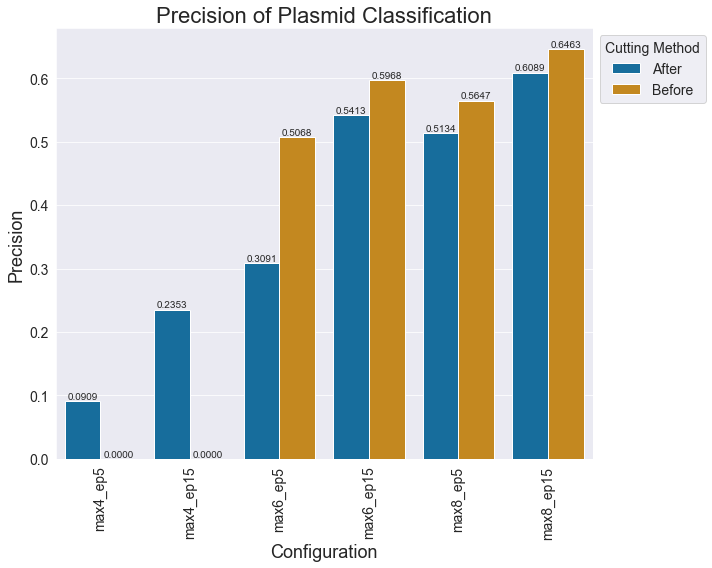

In [130]:
import seaborn as sns

plotdata = metrics.copy()
plotdata = plotdata.replace(['cutAfter_', 'cutBefore_'], ['', ''], regex=True)

for metric in ['Balanced Accuracy', 'Accuracy', 'MCC', 'FPR', 'F1S', 'TPR', 'TNR', 'FNR', 'Precision']:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(data=plotdata,
                x='ID',
                y=metric,
                hue='Cutting Method',
                palette=sns.color_palette('colorblind'))

    # place y-values above bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.4f')

    plt.title(f'{metric} of Plasmid Classification', fontsize=22)
    plt.xlabel('Configuration', fontsize=18)
    plt.ylabel(metric, fontsize=18)
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14
    ax.legend(title='Cutting Method', fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.savefig(f'../plots/{metric}.png', dpi=300, facecolor='white')
    #plt.close()

In [131]:
# TODO: several metrics in one plot

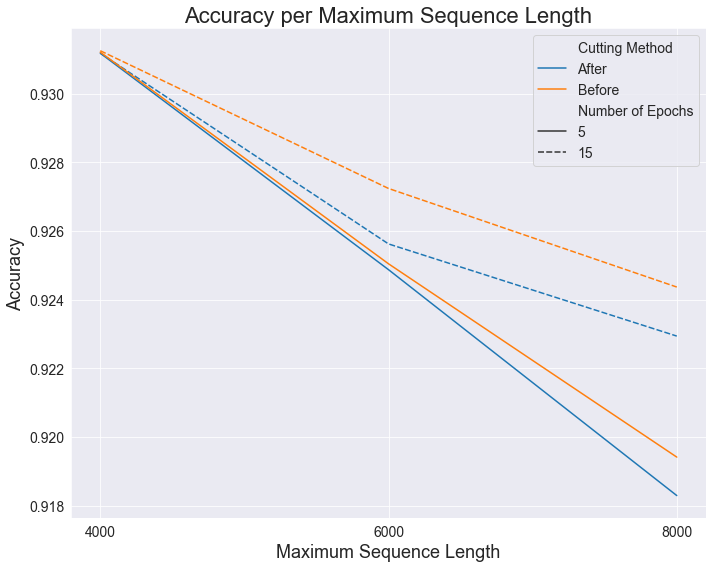

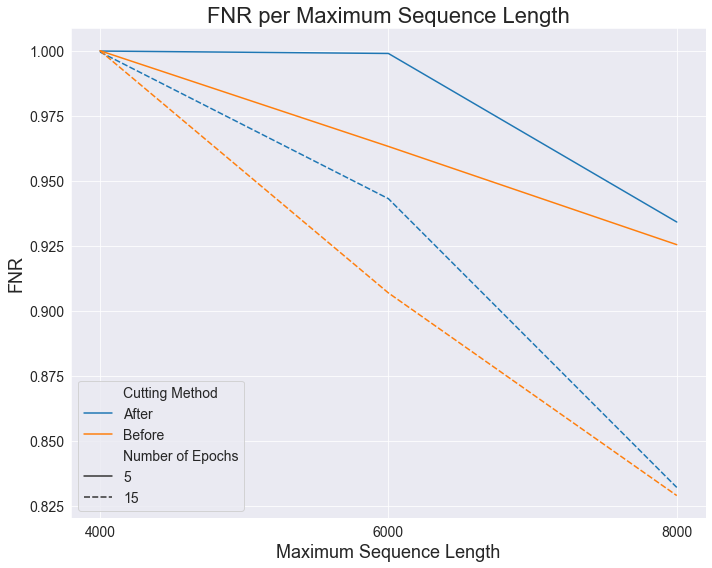

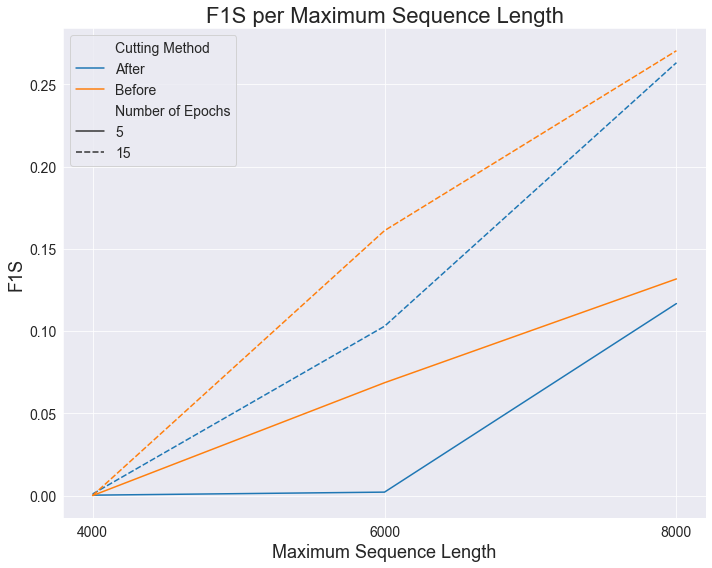

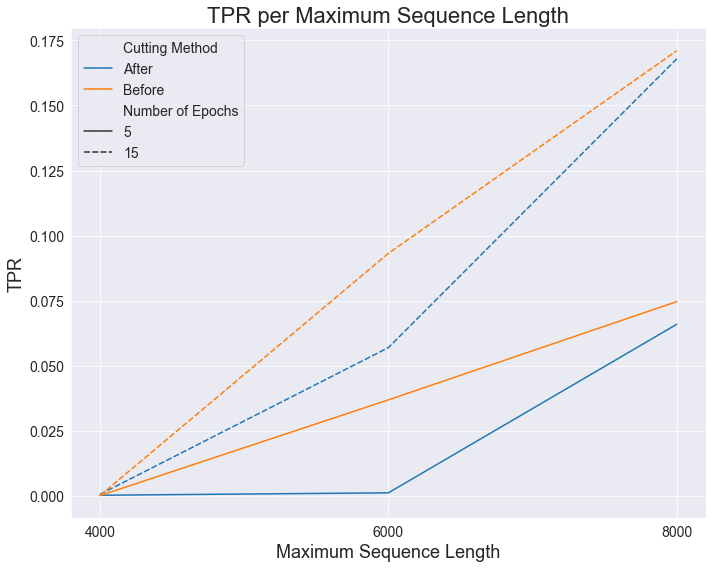

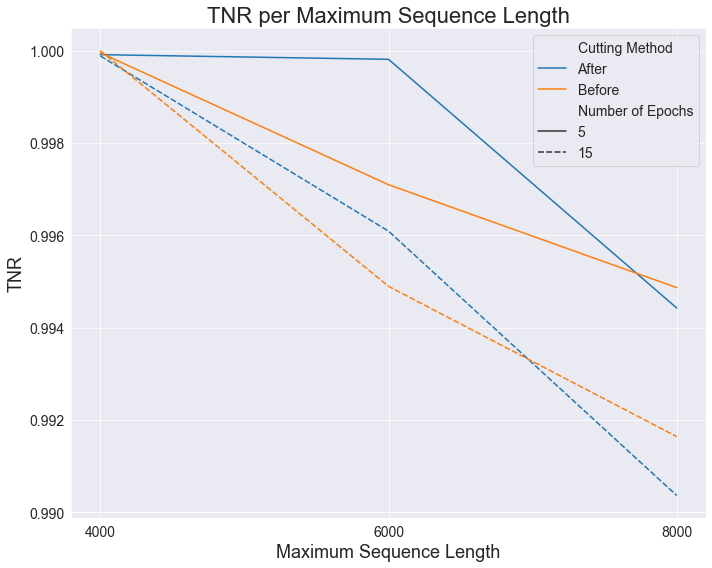

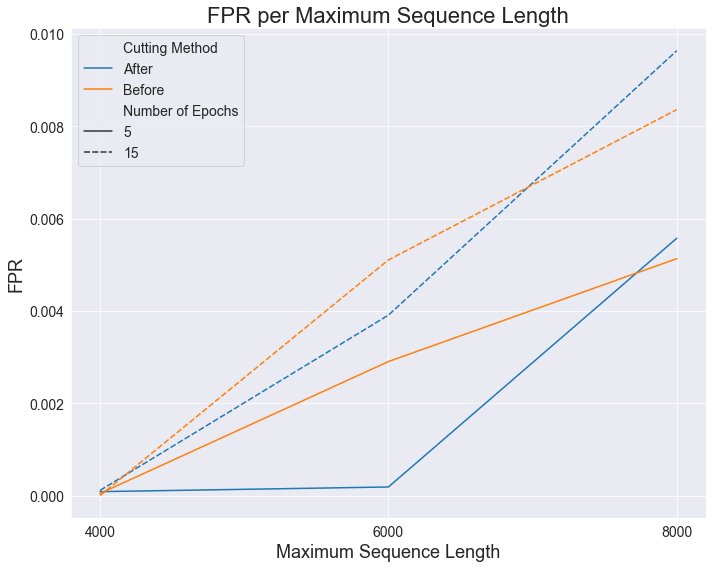

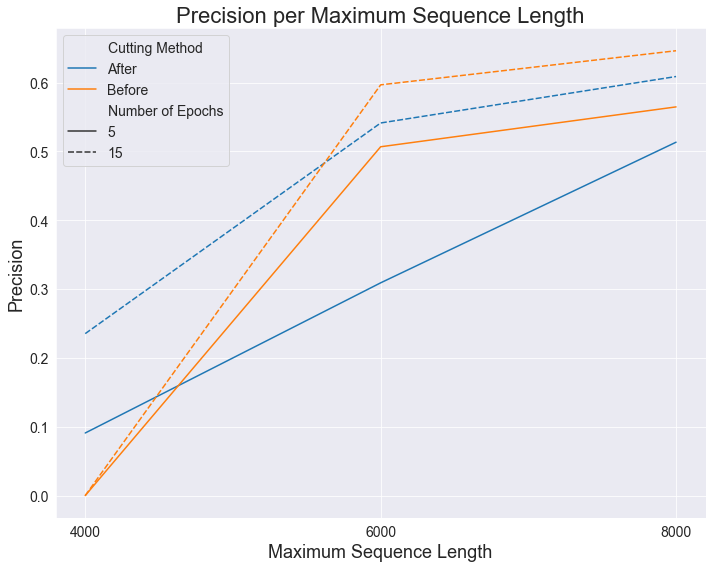

In [132]:
import seaborn as sns

plotdata = metrics.copy()
for metric in ['Accuracy', 'FNR', 'F1S', 'TPR', 'TNR', 'FPR', 'Precision']:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.lineplot(data=plotdata,
                 x='Maximum Sequence Length',
                 y=metric,
                 hue='Cutting Method',
                 style='Number of Epochs')

    plt.title(f'{metric} per Maximum Sequence Length', fontsize=22)
    plt.xlabel('Maximum Sequence Length', fontsize=18)
    plt.ylabel(metric, fontsize=18)
    plt.xticks(fontsize=14, ticks=plotdata['Maximum Sequence Length'], labels=plotdata['Maximum Sequence Length'].astype(str) + '000')
    plt.locator_params(axis='x', nbins=3)
    plt.yticks(fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 14
    ax.legend(fontsize=14)

    plt.tight_layout()
    plt.savefig(f'../plots/{metric}_per_max.png', dpi=300, facecolor='white')
    #plt.close()

In [133]:
import glob
import os

runtimes = pd.DataFrame(columns=['Maximum Sequence Length', 'Cutting Method', 'Number of Epochs', 'Runtime (min)'])

for filepath in glob.glob(f'{result_dir}/*.txt'):
    last_line = open(filepath, 'r').readlines()[-1]
    filename_splitted = os.path.basename(filepath).split('_')

    runtimes = pd.concat([runtimes,
                         pd.DataFrame({'Maximum Sequence Length': [filename_splitted[1][-1]],
                                       'Cutting Method': [filename_splitted[2][3:]],
                                       'Number of Epochs': [filename_splitted[3][:-10]],
                                       'Runtime (min)': [float(last_line.split(' ')[3]) / 60]})],
                         ignore_index=True)

runtimes

,Maximum Sequence Length,Cutting Method,Number of Epochs,Runtime (min)
0,4,After,15,8.416169
1,4,After,5,7.911258
2,4,Before,15,8.261873
3,4,Before,5,7.746769
4,6,After,15,8.921505
5,6,After,5,8.376060
6,6,Before,15,8.286654
7,6,Before,5,7.865699
8,8,After,15,11.604209
9,8,After,5,11.698651


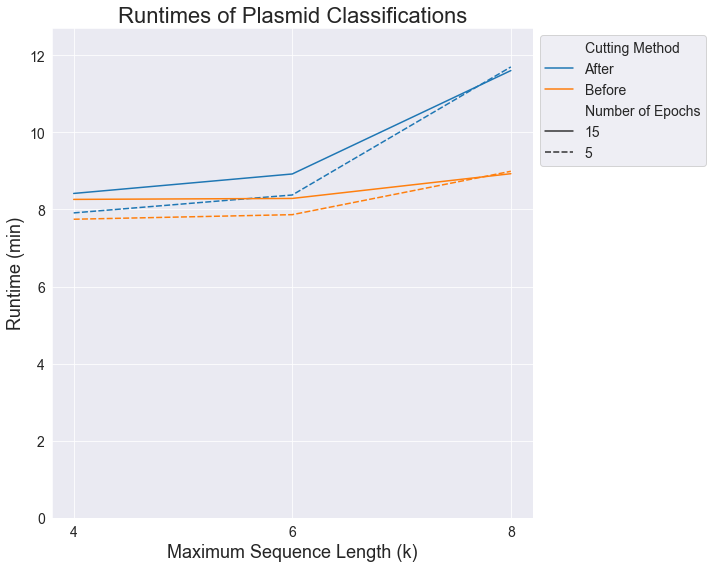

In [134]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=runtimes,
            x='Maximum Sequence Length',
            y='Runtime (min)',
            hue='Cutting Method',
            style='Number of Epochs')

# place y-values above bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f')

plt.title(f'Runtimes of Plasmid Classifications', fontsize=22)
ax.set(ylim=(0, runtimes['Runtime (min)'].max() + 1))
plt.xlabel('Maximum Sequence Length (k)', fontsize=18)
plt.ylabel('Runtime (min)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams['legend.title_fontsize'] = 14
ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig(f'../plots/runtimes.png', dpi=300, facecolor='white')
#plt.close()